# Image Processing - SCC5830
## Final Project - Visual analysis of hydrogen bubbles generated by electrolysis of water using Image Processing techniques
## Partial report
Authors: 
- Alexis J. Vargas  (Usp Number: 11939710) 
- Karelia A. Vilca (Usp Number: 11939727)

Semester 1, Year: 2020


## Abstract
The electrolysis of water process generates hydrogen bubbles, the analysis of these bubbles could give significant information about the process. This study focuses in analyse a video of the process of electrolysis of water using Image processing o get information of the tiny bubbles frame by frame. 

## Main Objetive
Detect and separate the bubbles in an area of the video, by analyzing frame by frame.
Apply the most appropriate technique for treating small and large bubbles.

## Input Images 

The experiment is based in a video taken of an electrolysis of water process, in which an electrode remains inside a recipient full of water, during the process of electrolysis the generated Hydrogen performs bubbles that goes from the electrode to the surface of the recipient.

The treated video is part of an experiment of the Institute of Physics of São Carlos (IFSC). 

It is formed by 18809 frames and has a resolution of 1920x1080 RGB pixels. Next we show a sample frame.


In [1]:
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
from skimage import img_as_float, feature, morphology

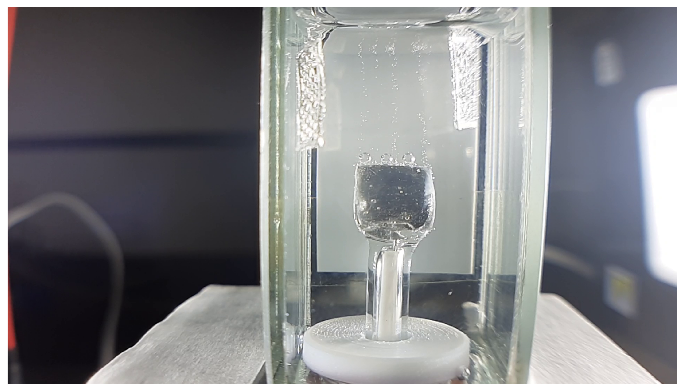

In [2]:
full_video = imageio.imread('../images/full_video.png')
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(full_video)

## Pipeline 


Description of steps to reach the objective, including the methods that are intented
to be used (e.g., image enhancement, edge-detection, morphology, segmentation,
texture analysis, color analysis, keypoint detection etc.). (2 pts)

1. Pre-processing: Extracting the area of interest.

2. Tiny Bubbles Analysis.

    2.1.  Gray-scale Conversion
    
    2.2.  Normalization [0 ... 1]
    
    2.3.  Edge Detection: Using canny edge detection algorithm.
    
    2.4.  Mathematical Morphology: Closing
    
    2.5.  Two-Sacan Labeling
    
    2.6.  Buuble Selection, Threshold
    

## Initial code
### 1. Pre-processing
Extracting the area of interest. The first step of the algorithm consist in delimit the region from where the bubbles start appearing until the top of the glass before where the bubbles disappear. This section of video is stored in a separate mp4 file.

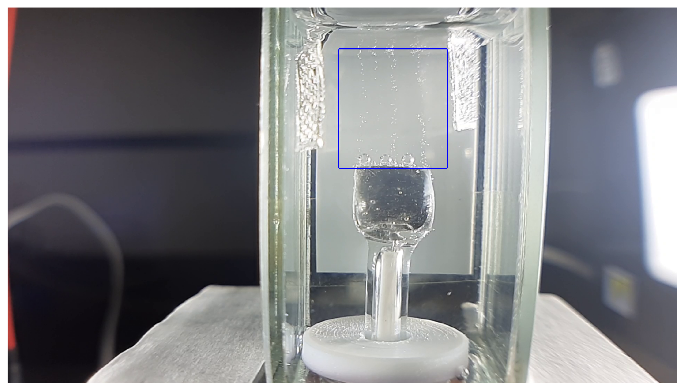

In [3]:
cut_video = imageio.imread('../images/section.png')
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(cut_video)

Here we get a frame of the sectional video.

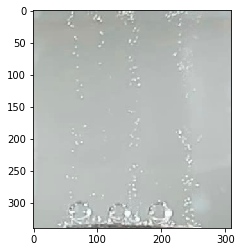

In [4]:
video = cv2.VideoCapture('../videos/Acid_310x340.mp4')
frame = None
for i in range(2500):
    ret, frame = video.read()
plt.imshow(frame)

### 2. Tiny Bubbles Analysis
#### 2.1. Gray-scale Conversion
Converting the image into gray-scale in order to work in only one channel, this will be done by calculating the mean value of the RGB channels.

In [5]:
# 2.1. Convert to grayscale
frame_gray = frame.mean(axis = 2)

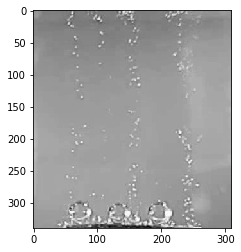

In [6]:
plt.imshow(frame_gray, cmap = 'gray')

#### 2.2. Normalization
It is necessary to standardize the image between the values of 0 and 1.

In [7]:
# 2.2. Set the intensities between 0 and 1
frame_float = img_as_float(frame_gray.astype(np.uint8))

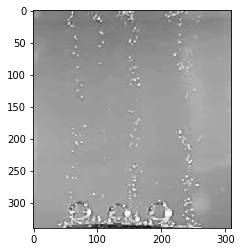

In [8]:
plt.imshow(frame_float, cmap = 'gray')

#### 2.3. Edge Detection
In this process canny edge detection algorithm is used to find the edges of all the bubbles, we use an explicit sigma value of 0.8 for the algorithm and the function feature.canny[2] to compute this part of the process. After the edge detection we have the bubbles surrounded by lines.

In [9]:
# 2.3. Get the edges using canny, sigma = 0.8
frame_edges = feature.canny(frame_float, sigma = 0.8)
frame_edges = img_as_float(frame_edges)

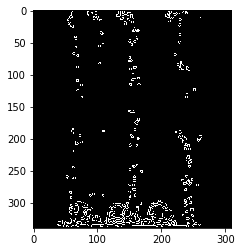

In [10]:
plt.imshow(frame_edges, cmap = 'gray')

#### 2.4. Mathematical Morphology
Now we apply mathematical morphology, we use a kernel of size 3x4 and perform the operations of dilation and erosion, these operations together are called by OpenCV[1] “Closing”. After this step all bubbles are marked separate from the noise and the background.

In [11]:
# 2.4. Closing the edges (morphological operation, first make dilation, second erosion) with a 3,4 kernel
kernel = np.ones((3,4),np.uint8)
frame_closing = morphology.closing(frame_edges, kernel)

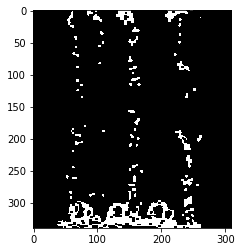

In [12]:
plt.imshow(frame_closing, cmap = 'gray')

#### 2.5. Two-Scan Labeling
The next step is to separate the bubbles labeling each one with a different label. The image shows the different labels obtained each one with a different level of intensity. To get this result we use the algorithm proposed in [5] that can perform this task in a linear time which is a good option due to we are going to perform the task for the entire video with 18809 frames.

In [13]:
Vo = 1000
Vb = 1001

def first_scan(img):
    '''
    rl_table: representative label table
    n_label : next equivalent label 
    t_label : last (tail) equivalent label
    '''
    b = img.copy().astype(np.int)
    b = np.pad(b,((1,1),(1,1)),'constant',constant_values=(Vb))
    b[b==0] = Vb
    b[b==1] = Vo
    X,Y = b.shape
    m = 1
    rl_table = {}
    n_label = {}
    t_label = {}
    for x in range(1,X-1):
        for y in range(1,Y-1):
            if b[x,y] != Vb:
                mask = [b[x-1,y-1],b[x-1,y],b[x-1,y+1],b[x,y-1]]
                
                b_min = min(mask)
                if b_min == Vb:
                    b[x,y] = m
                    rl_table[m] = m
                    n_label[m] = -1
                    t_label[m] = m
                    m += 1
                else:
                    j = b_min
                    b[x,y] = j
                    for k in mask:
                        if k < Vo:
                            if rl_table[j] != rl_table[k]:
                                if rl_table[j] < rl_table[k]:
                                    u = rl_table[j]
                                    v = rl_table[k]
                                else:
                                    v = rl_table[j]
                                    u = rl_table[k]
                                i = v
                                while(i > -1):
                                    rl_table[i] = u
                                    i = n_label[i]
                                n_label[t_label[u]] = v
                                t_label[u] = t_label[v]
    return (img, b[1:-1,1:-1], rl_table, n_label, t_label)

def second_scan(b, rlt):
    '''
    b: output b from first scan
    rlt: representative label table
    '''
    for r in rlt:
        b[b==r] = rlt[r]
    b[b==Vb] = 0
    return b

def two_scan_labeling(img):
    '''
    img: binary image (0,1) (0: background)
    '''
    img, b, rl_table, _, _ = first_scan(img)
    res = second_scan(b, rl_table)
    return res

In [14]:
# 2.5. Labeling
frame_labeled = two_scan_labeling(frame_closing)

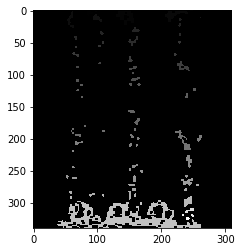

In [15]:
plt.imshow(frame_labeled, cmap = 'gray')

#### 2.6.  Buuble Selection, Threshold
With the labels separated, we can notice some objects labeled that are not of out interest, these are the big bubbles and the small portion of the electrode in the bottom of the image. We can solve this by using a quantity of pixels threshold in the labels, so we only take in count the small labels.

In [16]:
# 6. Remove big labels (more than 500 pixels)
frame_labeled_th = frame_labeled.copy()
labels = np.unique(frame_labeled)
for l in labels[1:]:
    s = frame_labeled[frame_labeled == l].shape[0]
    if s > 500:
        frame_labeled_th[frame_labeled == l] = 0

In [17]:
# Making the labels more intense to make them visible
frame_labeled = 255 - frame_labeled
frame_labeled[frame_labeled == 255] = 0
frame_labeled_th = 255 - frame_labeled_th
frame_labeled_th[frame_labeled_th == 255] = 0

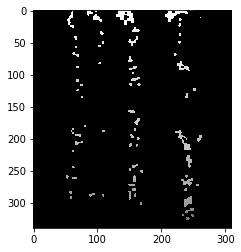

In [18]:
plt.imshow(frame_labeled_th, cmap = 'gray')

## Process summary

Next we can see all the transformations that the frame has had

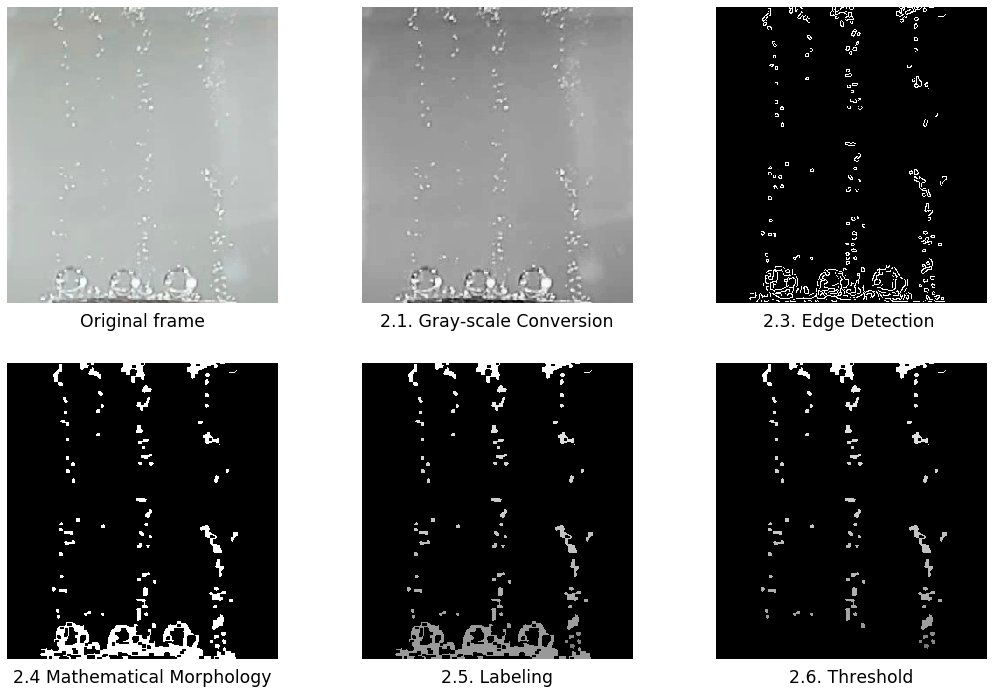

In [19]:
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
plt.axis('off')
plt.title('Original frame', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame)
plt.subplot(2,3,2)
plt.axis('off')
plt.title('2.1. Gray-scale Conversion', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame_gray, cmap = 'gray')
plt.subplot(2,3,3)
plt.axis('off')
plt.title('2.3. Edge Detection ', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame_edges, cmap = 'gray')
plt.subplot(2,3,4)
plt.axis('off')
plt.title('2.4 Mathematical Morphology', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame_closing, cmap = 'gray')
plt.subplot(2,3,5)
plt.axis('off')
plt.title('2.5. Labeling', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame_labeled, cmap = 'gray', vmin = 0, vmax = 255)
plt.subplot(2,3,6)
plt.axis('off')
plt.title('2.6. Threshold', y=-0.1, fontsize = 'xx-large')
plt.imshow(frame_labeled_th, cmap = 'gray', vmin = 0, vmax = 255)

The next steps to develop are:
* Treat larger bubbles with appropriate algorithms.
* Show labeled bubbles visually.

**References**

[1] OpenCV, https://opencv.org/

[2] scikit-image: Image processing in Python — scikit-image, https://scikit-image.org/

[3] He, L., Chao, Y., Suzuki, K.: A linear-time two-scan labeling algorithm. In: 2007
IEEE International Conference on Image Processing. vol. 5, pp. V – 241–V – 244
(Sep 2007). https://doi.org/10.1109/ICIP.2007.4379810